# import packages:

In [1]:
import pandas as pd
import datetime
import numpy as np
import urllib.request
import zipfile
import os
import matplotlib.pyplot as plt
# Time Series Clustering
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

# download dataset and unzip file:

In [2]:
# only download if file does not exist yet:
if not os.path.exists('LD2011_2014.txt'):
    # Define URL
    URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"
    # Download the file from `URL` and save it locally under `file_name`:
    urllib.request.urlretrieve(URL, "LD2011_2014.txt.zip")
    # Unzip file:
    zip_ref = zipfile.ZipFile("LD2011_2014.txt.zip", 'r')
    zip_ref.extractall()
    zip_ref.close()

# read dataset:

In [3]:
# open raw file downloaded to local machine:
raw_file_path = 'LD2011_2014.txt'

# use raw file to read csv and get raw dataframe:
raw_dataset = pd.read_csv(raw_file_path, delimiter=';', header=0, decimal=',', index_col=False, low_memory=False)

# check dataframe info and head:
print(raw_dataset.info())
print(raw_dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140256 entries, 0 to 140255
Columns: 371 entries, Unnamed: 0 to MT_370
dtypes: float64(370), object(1)
memory usage: 397.0+ MB
None
            Unnamed: 0  MT_001  MT_002  MT_003  MT_004  MT_005  MT_006   
0  2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0  \
1  2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0   
2  2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0   
3  2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0   
4  2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_007  MT_008  MT_009  ...  MT_361  MT_362  MT_363  MT_364  MT_365   
0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0  \
1     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
4  

# rename column containing dates' in string format and convert it to datetime format:

In [5]:
# since column with datetime values doesn't have name, rename it to 'datetime':
data_timecol = raw_dataset.rename(columns={'Unnamed: 0':'datetime'})

# check dtypes for dataframe before converstion of 'datetime' column to datetime dtype:
print(data_timecol.dtypes)

# transform rennamed column into datetime dtype:
data_timecol['datetime'] = pd.to_datetime(data_timecol['datetime'], format='%Y-%m-%d %H:%M:%S')

# check if conversion was successful:
print(data_timecol.dtypes.value_counts())

datetime     object
MT_001      float64
MT_002      float64
MT_003      float64
MT_004      float64
             ...   
MT_366      float64
MT_367      float64
MT_368      float64
MT_369      float64
MT_370      float64
Length: 371, dtype: object
float64           370
datetime64[ns]      1
Name: count, dtype: int64


# resample data from 15min frequency to hourly frequency:

In [6]:
# resample data from 15min level to hourly level:
data_resamp = data_timecol.resample('1H', on='datetime').sum().reset_index()

# get length of data_resamp:
data_resamp_length = len(data_resamp)

# check to see if resampling went through:
print(data_resamp.head())

             datetime  MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007   
0 2011-01-01 00:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  \
1 2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2 2011-01-01 02:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3 2011-01-01 03:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4 2011-01-01 04:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_008  MT_009  ...  MT_361  MT_362  MT_363  MT_364  MT_365  MT_366   
0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0  \
1     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_367  MT_368  MT_369  MT_370  
0     0.0     0.0     0.0     0.

# to get tidy dataframe, use melt to pivot dataframe and get it vertically stacked:

In [7]:
resampled_data = data_resamp

# stack dataset by melting it (the value_name col will be recalculated after):
melted_data = pd.melt(resampled_data, id_vars=['datetime'], var_name='client_id', value_name='KwH')

# Remove 'MT_' from client_id col:
melted_data['client_id'] = melted_data['client_id'].str.replace('MT_', '').astype(int)
print(melted_data.head())

             datetime  client_id  KwH
0 2011-01-01 00:00:00          1  0.0
1 2011-01-01 01:00:00          1  0.0
2 2011-01-01 02:00:00          1  0.0
3 2011-01-01 03:00:00          1  0.0
4 2011-01-01 04:00:00          1  0.0


# For client data that started late and ended early, get first and last nonzero dates for each client:

In [9]:
cutoff_dates = melted_data[melted_data['KwH'] != 0].groupby('client_id', as_index=False).agg(
    min=('datetime','min'),
    max=('datetime','max')
    )

print(cutoff_dates.tail())
print(melted_data.head())

     client_id        min        max
365        366 2012-01-01 2015-01-01
366        367 2012-01-01 2015-01-01
367        368 2012-01-01 2015-01-01
368        369 2012-01-01 2015-01-01
369        370 2013-01-01 2015-01-01
             datetime  client_id  KwH
0 2011-01-01 00:00:00          1  0.0
1 2011-01-01 01:00:00          1  0.0
2 2011-01-01 02:00:00          1  0.0
3 2011-01-01 03:00:00          1  0.0
4 2011-01-01 04:00:00          1  0.0


# if client presents empty rows at the start or the end of the dataframe, get rid of it:

In [10]:
tmp = melted_data.copy()

def filter_rows_before_after_date(df, cutoff_dates):
    df = df.merge(cutoff_dates, on='client_id', how='left')
    df['is_before_start'] = df['datetime'] < df['min']
    df['is_after_end'] = df['datetime'] > df['max']
    df.drop(df[df.is_before_start == True].index, inplace=True)
    df.drop(df[df.is_after_end == True].index, inplace=True)
    df.drop(['is_before_start', 'is_after_end', 'min', 'max'], axis=1, inplace=True)
    return df

melted_data = filter_rows_before_after_date(melted_data, cutoff_dates)
melted_data.head()

,datetime,client_id,KwH
8760,2012-01-01 00:00:00,1,12.690355
8761,2012-01-01 01:00:00,1,16.497462
8762,2012-01-01 02:00:00,1,19.035533
8763,2012-01-01 03:00:00,1,17.766497
8764,2012-01-01 04:00:00,1,19.035533


# round 'KwH' values to 2 decimals and check for zero values that would not be registered as NaN originally because of near-zero instances:

In [11]:
hard_zero_counts = melted_data[melted_data['KwH'] == 0].groupby('client_id').size().sort_values(ascending=False)

print(hard_zero_counts.head(20))

client_id
132    19073
131    15653
347    15638
130    14213
348    12189
15      2640
66      2339
133     1945
127     1065
288      523
3        149
123       50
1         38
340       38
57        32
143       32
346       31
370       30
336       29
151       28
dtype: int64


In [12]:
# create new column 'KwH_round' round and round values to 2 decimals:
melted_data['KwH_round'] = melted_data['KwH'].round(2)

# check size of zero values in KwH_round column for each client_id:
zero_counts = melted_data[melted_data['KwH_round'] == 0].groupby('client_id').size()

# drop KwH_round column:
melted_data.drop('KwH_round', axis=1, inplace=True)

# sort values in descending order:
zero_counts = zero_counts.sort_values(ascending=False)

# get number of observations for each client_id:
client_counts = melted_data.groupby('client_id').size()

# combine zero_counts and client_counts into zero_counts_df:
zero_counts_df = pd.DataFrame({'zero_counts': zero_counts, 'client_counts': client_counts})

# create new column 'zero_counts_ratio' and calculate ratio of zero_counts to client_counts:
zero_counts_df['zero_counts_ratio'] = (zero_counts_df['zero_counts'] * 100 / zero_counts_df['client_counts']).round(2)

# sort values in descending order:
zero_counts_df = zero_counts_df.sort_values(by='zero_counts_ratio', ascending=False)

# check zero_counts_df:
print(zero_counts_df.head(20))


           zero_counts  client_counts  zero_counts_ratio
client_id                                               
347            15638.0          25981              60.19
132            19073.0          35065              54.39
130            14213.0          26305              54.03
348            12189.0          26304              46.34
131            15653.0          35065              44.64
133             1945.0           7041              27.62
15              2640.0          13811              19.12
66              2339.0          26305               8.89
127             1065.0          21937               4.85
288              523.0          35065               1.49
3                149.0          26305               0.57
178               23.0           4009               0.57
181               23.0           7249               0.32
337               23.0           8377               0.27
179               23.0           9049               0.25
123               50.0         

In [13]:
# if 'mov_avg_24h' doesn't exist, create rolling window of 24 hours:
if 'mov_avg_24h' not in melted_data.columns:
    melted_data['mov_avg_24h'] = melted_data.groupby('client_id')['KwH'].rolling(24).mean().reset_index(0,drop=True)

# check data:
print(melted_data.tail(10))

                    datetime  client_id           KwH   mov_avg_24h
12974040 2014-12-31 15:00:00        370  57513.513514  70704.954955
12974041 2014-12-31 16:00:00        370  49837.837838  69198.198198
12974042 2014-12-31 17:00:00        370  46432.432432  67718.468468
12974043 2014-12-31 18:00:00        370  40540.540541  66141.891892
12974044 2014-12-31 19:00:00        370  35891.891892  64218.468468
12974045 2014-12-31 20:00:00        370  33621.621622  62430.180180
12974046 2014-12-31 21:00:00        370  33135.135135  60623.873874
12974047 2014-12-31 22:00:00        370  30378.378378  58765.765766
12974048 2014-12-31 23:00:00        370  27729.729730  56912.162162
12974049 2015-01-01 00:00:00        370   7135.135135  54317.567568


## Use Case: Finding groups of clients with similar consumption patterns

* First Step: Apply Dynamic Time Warping (DTW) with DBA (Dynamic Barycenter Averaging) to find groups of clients with similar consumption patterns.
* Second Step: Apply K-Means to find groups of clients with similar consumption patterns. (Find optimal number of clusters)
* Third Step: Get a dataframe with clients' IDs and their respective groups.
* Fourth Step: Identify patterns of consumption for each group.

In [50]:
# Get most recent date in cutoff_dates['max']:
max_date = cutoff_dates['max'].max()
# filter clients with max_data prior to max_date:
non_active_clients_list = cutoff_dates[cutoff_dates['max'] < max_date]['client_id'].unique().tolist()
active_clients_list = set(cutoff_dates['client_id'].unique().tolist()) - set(non_active_clients_list)
active_clients = melted_data[
    melted_data['client_id'].isin(active_clients_list)
]    
#
client_df = pd.DataFrame(
    {'client_id': active_clients['client_id'].unique()}
)
# Let's get one week of data for each client:
active_clients = active_clients[active_clients['datetime'] >= max_date - pd.DateOffset(weeks=1)]

In [51]:
# transform active_clients dataframe into a numpy array with (n_ts_test, sz, d) format, that means: number of time series, their size and their dimensionality (1).
active_clients_tslearn_format = active_clients.groupby('client_id')['KwH'].apply(list).values.tolist()
active_clients_tslearn_format = np.array(active_clients_tslearn_format)
sz = active_clients_tslearn_format.shape[1]
active_clients_tslearn_format = active_clients_tslearn_format.reshape(-1, sz, 1)
active_clients_tslearn_format.shape

(367, 169, 1)

In [52]:
seed = 0
# Scale the data:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
active_clients_tslearn_format = scaler.fit_transform(active_clients_tslearn_format)
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(active_clients_tslearn_format)
client_df['client_groups'] = y_pred

82.492 --> 53.899 --> 52.696 --> 51.163 --> 50.470 --> 50.206 --> 50.156 --> 50.074 --> 49.947 --> 49.932 --> 49.932 --> 


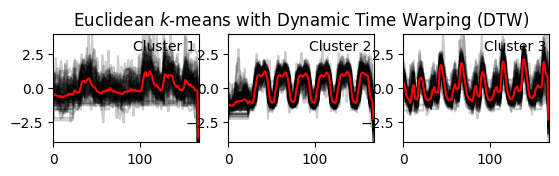

In [55]:
plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in active_clients_tslearn_format[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means with Dynamic Time Warping (DTW)")